In [1]:
pip install cryptocompare

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas_ta

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt

In [7]:
def load_data(filepath):
    df = pd.read_csv(filepath, index_col='timestamp', parse_dates=True)
    df = df[["open", "high", "low", "close", "volume"]].astype(float)
    df = df.sort_index()
    return df

In [9]:
filepath = "BTCUSDT_1min_2024-05-01_to_2025-05-01.csv"
df = load_data(filepath)
print(df.head())

                         open      high       low     close    volume
timestamp                                                            
2024-04-30 16:00:00  60796.86  60819.07  60713.22  60815.04  55.38665
2024-04-30 16:01:00  60815.04  60815.05  60688.80  60707.61  26.68472
2024-04-30 16:02:00  60707.61  60707.61  60616.04  60671.50  41.16678
2024-04-30 16:03:00  60671.51  60824.38  60649.01  60794.13  31.65158
2024-04-30 16:04:00  60794.12  60892.41  60793.97  60892.40  29.64754


In [11]:
def calculate_indicators(df):
    df['OBV'] = ta.obv(df['close'], df['volume'])
    df['AD'] = ta.ad(df['high'], df['low'], df['close'], df['volume'])
    df['ADOSC'] = ta.adosc(df['high'], df['low'], df['close'], df['volume'], fast=3, slow=10)
    df['MFI'] = ta.mfi(df['high'], df['low'], df['close'], df['volume'], length=14)
    df['BOP'] = ta.bop(df['open'], df['high'], df['low'], df['close'])
    return df

In [13]:
def generate_signals(df):
    mfi_low = df['MFI'].quantile(0.2)
    mfi_high = df['MFI'].quantile(0.8)
    print(f" MFI ：Buy < {mfi_low:.2f}，Sale > {mfi_high:.2f}")

    for name in ['OBV', 'AD', 'ADOSC', 'MFI', 'BOP']:
        df[f'Signal_{name}'] = 0

    for i in range(3, len(df), 3):
        if df['OBV'][i] > df['OBV'][i - 3]:
            df.at[df.index[i], 'Signal_OBV'] = 1
        elif df['OBV'][i] < df['OBV'][i - 3]:
            df.at[df.index[i], 'Signal_OBV'] = -1

        if df['AD'][i] > df['AD'][i - 3]:
            df.at[df.index[i], 'Signal_AD'] = 1
        elif df['AD'][i] < df['AD'][i - 3]:
            df.at[df.index[i], 'Signal_AD'] = -1

        if df['ADOSC'][i] > 0:
            df.at[df.index[i], 'Signal_ADOSC'] = 1
        elif df['ADOSC'][i] < 0:
            df.at[df.index[i], 'Signal_ADOSC'] = -1

        if df['MFI'][i] < mfi_low:
            df.at[df.index[i], 'Signal_MFI'] = 1
        elif df['MFI'][i] > mfi_high:
            df.at[df.index[i], 'Signal_MFI'] = -1

        if df['BOP'][i] > 0:
            df.at[df.index[i], 'Signal_BOP'] = 1
        elif df['BOP'][i] < 0:
            df.at[df.index[i], 'Signal_BOP'] = -1

    return df

In [15]:
def backtest_signals(df, signal_col, max_print=50):
    initial_cash = 10000
    position = 0
    cash = initial_cash

    buy_count = 0
    sell_count = 0

    print(f"\n--- Backtest：{signal_col} ---")
    for i in range(1, len(df)):
        signal = df[signal_col][i]
        price = df['close'][i]

        if signal == 1 and position == 0:
            position = cash / price
            cash = 0
            if buy_count < max_print:
                print(f"Buy：{df.index[i]}，Price：{price:.2f}")
            buy_count += 1

        elif signal == -1 and position > 0:
            cash = position * price
            position = 0
            if sell_count < max_print:
                print(f"Sale：{df.index[i]}，Price：{price:.2f}")
            sell_count += 1

    final_balance = cash + position * df['close'].iloc[-1]
    print(f"{signal_col} Final Balance: ${final_balance:.2f}")
    print(f"(Bought {buy_count} times in total, sold {sell_count} times, only the first {max_print} items are shown)")
    return final_balance

In [17]:
def plot_signals(df, symbol):
    plt.figure(figsize=(60, 15))

    plt.subplot(6, 1, 1)
    plt.plot(df['close'], label='Close', color='black')
    plt.title(f'{symbol} Close Price')
    plt.legend()

    plt.subplot(6, 1, 2)
    plt.plot(df['OBV'], label='OBV', color='blue')
    plt.title('OBV')
    plt.legend()

    plt.subplot(6, 1, 3)
    plt.plot(df['AD'], label='AD', color='green')
    plt.title('Accumulation/Distribution Line')
    plt.legend()

    plt.subplot(6, 1, 4)
    plt.plot(df['ADOSC'], label='ADOSC', color='red')
    plt.title('Chaikin AD Oscillator')
    plt.legend()

    plt.subplot(6, 1, 5)
    plt.plot(df['MFI'], label='MFI', color='cyan')
    plt.title('Money Flow Index')
    plt.legend()

    plt.subplot(6, 1, 6)
    plt.plot(df['BOP'], label='BOP', color='magenta')
    plt.title('Balance of Power')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
def run_full_strategy():
    filepath = "BTCUSDT_1min_2024-05-01_to_2025-05-01.csv"
    df = load_data(filepath)
    df = calculate_indicators(df)
    df = generate_signals(df)

    results = {}
    for name in ['OBV', 'AD', 'ADOSC', 'MFI', 'BOP']:
        col = f'Signal_{name}'
        bal = backtest_signals(df, col)
        results[name] = bal
 
    print("\n--- Top 3 ---")
    top3 = sorted(results.items(), key=lambda x: x[1], reverse=True)[:3]
    for i, (name, bal) in enumerate(top3, 1):
        print(f"{i}. {name} - Final_Balance：${bal:.2f}")

    plot_signals(df, symbol="BTCUSDT")
    
    return df

C:\Users\XIE\AppData\Local\Temp\ipykernel_52284\2920143886.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1923018.3302272  1804337.22773373 4086827.22015617 ...  262116.01155203
  304965.5125025   800891.4036765 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['MFI'] = ta.mfi(df['high'], df['low'], df['close'], df['volume'], length=14)
C:\Users\XIE\AppData\Local\Temp\ipykernel_52284\2920143886.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1620753.93029707 2497384.767039   1017889.773201   ... 1223844.46574717
  649343.9226456   559456.1244543 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['MFI'] = ta.mfi(df['high'], df['low'], df['close'], df['volume'], length=14)


 MFI ：Buy < 31.93，Sale > 67.89


C:\Users\XIE\AppData\Local\Temp\ipykernel_52284\1923246767.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['OBV'][i] > df['OBV'][i - 3]:
C:\Users\XIE\AppData\Local\Temp\ipykernel_52284\1923246767.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['OBV'][i] < df['OBV'][i - 3]:
C:\Users\XIE\AppData\Local\Temp\ipykernel_52284\1923246767.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['AD'][i] > df['AD'][


--- Backtest：Signal_OBV ---
Buy：2024-04-30 16:21:00，Price：60551.18
Sale：2024-04-30 16:24:00，Price：60367.28
Buy：2024-04-30 16:27:00，Price：60385.28
Sale：2024-04-30 16:30:00，Price：60276.67
Buy：2024-04-30 16:36:00，Price：60331.99
Sale：2024-04-30 16:45:00，Price：60446.20
Buy：2024-04-30 16:48:00，Price：60435.50
Sale：2024-04-30 16:54:00，Price：60373.67
Buy：2024-04-30 17:03:00，Price：60494.96
Sale：2024-04-30 17:06:00，Price：60445.30
Buy：2024-04-30 17:24:00，Price：60449.33
Sale：2024-04-30 17:30:00，Price：60347.62
Buy：2024-04-30 17:33:00，Price：60328.11
Sale：2024-04-30 17:36:00，Price：60218.01
Buy：2024-04-30 17:45:00，Price：60134.44
Sale：2024-04-30 17:48:00，Price：60142.58
Buy：2024-04-30 17:51:00，Price：60350.02
Sale：2024-04-30 17:54:00，Price：60324.43
Buy：2024-04-30 17:57:00，Price：60360.39
Sale：2024-04-30 18:06:00，Price：60372.14
Buy：2024-04-30 18:09:00，Price：60388.42
Sale：2024-04-30 18:21:00，Price：60423.65
Buy：2024-04-30 18:27:00，Price：60399.01
Sale：2024-04-30 18:30:00，Price：60242.56
Buy：2024-04-30 18:33:00

C:\Users\XIE\AppData\Local\Temp\ipykernel_52284\3804440006.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = df[signal_col][i]


Signal_OBV Final Balance: $6364.60
(Bought 43585 times in total, sold 43585 times, only the first 50 items are shown)

--- Backtest：Signal_AD ---
Buy：2024-04-30 16:03:00，Price：60794.13
Sale：2024-04-30 16:06:00，Price：60783.50
Buy：2024-04-30 16:15:00，Price：60691.14
Sale：2024-04-30 16:18:00，Price：60445.63
Buy：2024-04-30 16:21:00，Price：60551.18
Sale：2024-04-30 16:24:00，Price：60367.28
Buy：2024-04-30 16:27:00，Price：60385.28
Sale：2024-04-30 16:30:00，Price：60276.67
Buy：2024-04-30 16:36:00，Price：60331.99
Sale：2024-04-30 16:48:00，Price：60435.50
Buy：2024-04-30 16:51:00，Price：60537.39
Sale：2024-04-30 16:54:00，Price：60373.67
Buy：2024-04-30 16:57:00，Price：60414.49
Sale：2024-04-30 17:00:00，Price：60258.93
Buy：2024-04-30 17:03:00，Price：60494.96
Sale：2024-04-30 17:09:00，Price：60403.58
Buy：2024-04-30 17:18:00，Price：60261.24
Sale：2024-04-30 17:30:00，Price：60347.62
Buy：2024-04-30 17:45:00，Price：60134.44
Sale：2024-04-30 17:48:00，Price：60142.58
Buy：2024-04-30 17:51:00，Price：60350.02
Sale：2024-04-30 17:54:00，

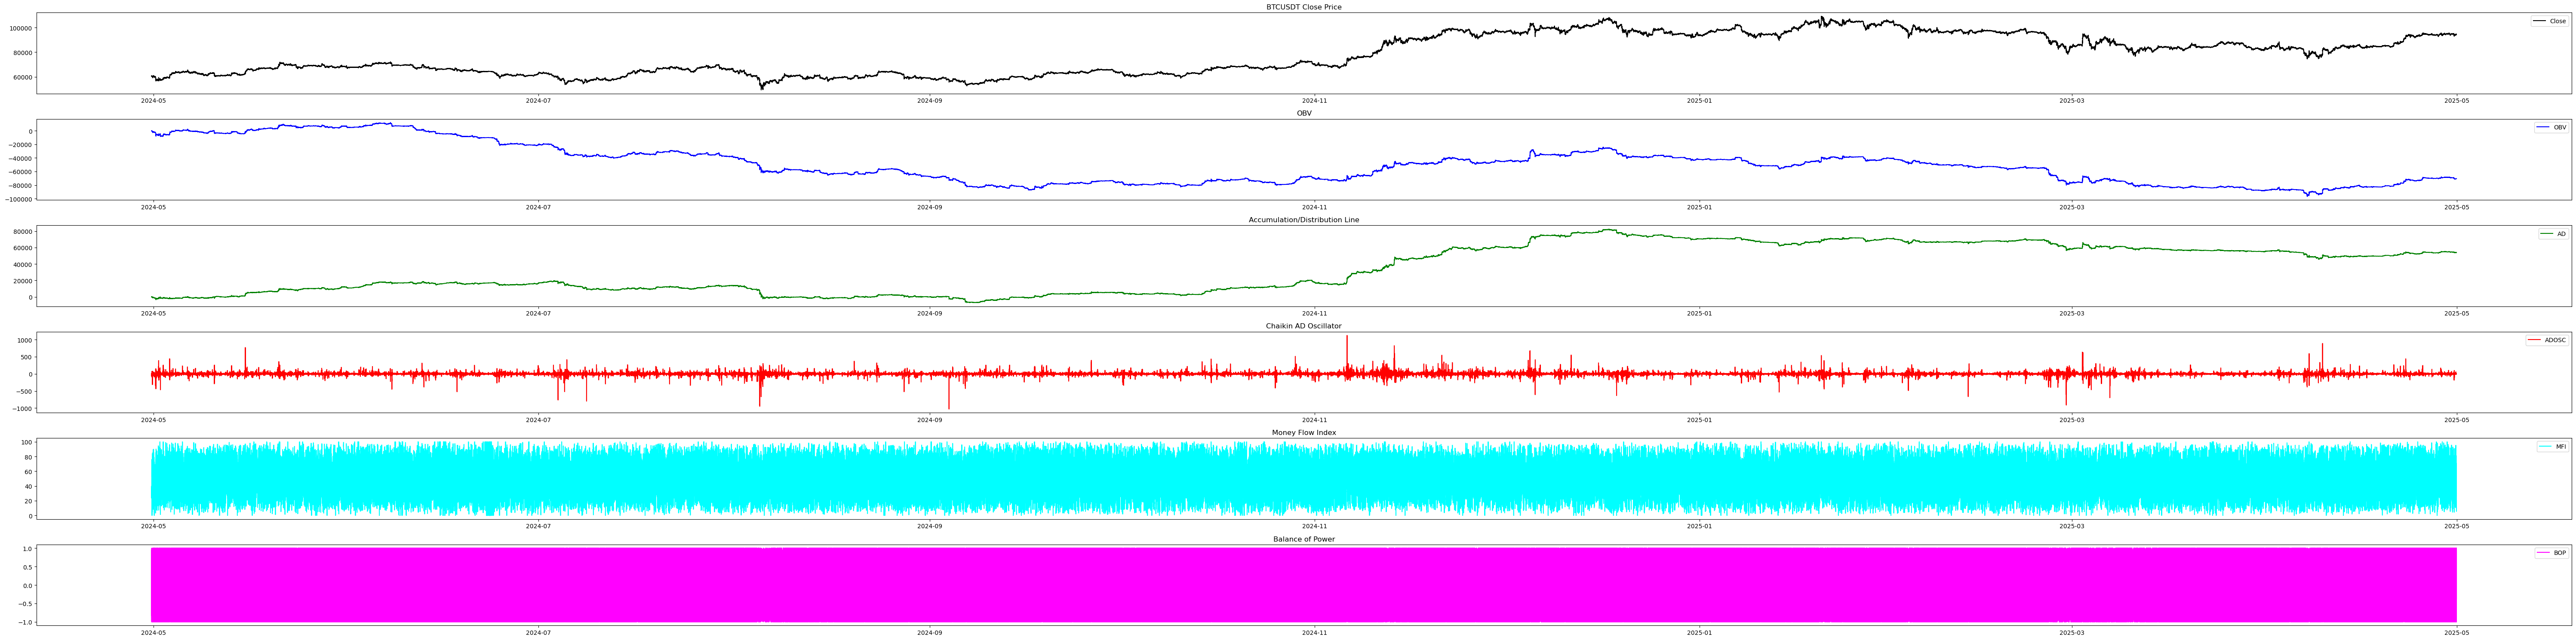

In [23]:
df = run_full_strategy()